2024-12-24 12:46:39,710 - INFO - Initializing Quantum Boltzmann Machine (QBM)
2024-12-24 12:46:39,717 - INFO - Initializing Data Loaders
2024-12-24 12:46:39,766 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-24 12:46:39,790 - INFO - Loaded 2880 samples.
2024-12-24 12:46:39,791 - INFO - Data Loaders initialized: 2304 training samples, 576 testing samples
2024-12-24 12:46:43,638 - INFO - Training data shape: (2304, 4)
2024-12-24 12:46:43,646 - INFO - Testing data shape: (576, 4)
2024-12-24 12:46:43,648 - INFO - Starting QBM training...


Epoch 10/100, Loss: 25.5008
Epoch 20/100, Loss: 25.5008
Epoch 30/100, Loss: 25.5008
Epoch 40/100, Loss: 25.5008
Epoch 50/100, Loss: 25.5008
Epoch 60/100, Loss: 25.5008
Epoch 70/100, Loss: 25.5008
Epoch 80/100, Loss: 25.5008
Epoch 90/100, Loss: 25.5008


2024-12-24 12:52:18,466 - INFO - QBM training completed.
2024-12-24 12:52:18,469 - INFO - Extracting features and training k-NN classifier...


Epoch 100/100, Loss: 25.5008


2024-12-24 12:52:21,345 - INFO - k-NN classifier trained on QBM features.
2024-12-24 12:52:21,346 - INFO - k-NN classifier training completed.
2024-12-24 12:52:21,346 - INFO - Predicting on test data...
2024-12-24 12:52:22,064 - INFO - QBM Classifier Accuracy: 10.07%
/Users/sahajrajmalla/Documents/nepali-quantum-mnist/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sahajrajmalla/Documents/nepali-quantum-mnist/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/s

QBM Classifier Accuracy: 10.07%
Confusion Matrix:
[[ 0  7 14 16 15  0  8  5  0  1]
 [ 0  6  8 13  0  9  4  6  0 10]
 [ 0  9 16  6  1  3 10  6  0  7]
 [ 0 12  9  8  7  1  8  2  0  2]
 [ 0 11 12 10 12  2 13  6  0  1]
 [ 0  4  2  4  2  2  2 26  0  4]
 [ 0 23 15 14  9  0  3  1  0  0]
 [ 0 19  3  7  2  2  8  6  0 15]
 [ 0  1 18 10  6 10  5  5  0  0]
 [ 0  9  8 12  5  0  9  4  0  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.06      0.11      0.08        56
           2       0.15      0.28      0.20        58
           3       0.08      0.16      0.11        49
           4       0.20      0.18      0.19        67
           5       0.07      0.04      0.05        46
           6       0.04      0.05      0.04        65
           7       0.09      0.10      0.09        62
           8       0.00      0.00      0.00        55
           9       0.11      0.10      0.10        52



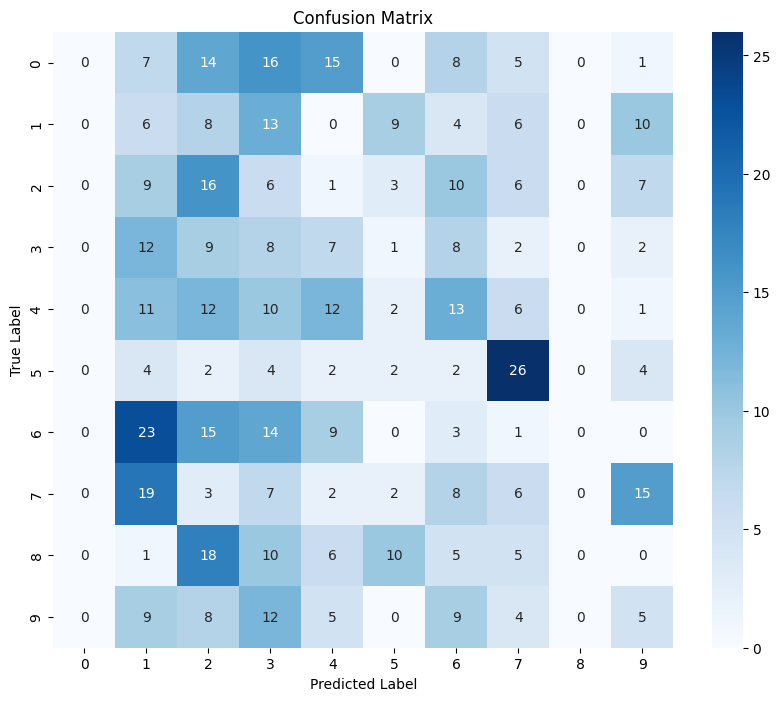

AttributeError: 'Subset' object has no attribute 'data'

In [2]:
# qbm_classifier.py

"""
Quantum Boltzmann Machine (QBM) for Nepali Numerals Classification.

This script implements a QBM using PennyLane and PyTorch to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QBM leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical k-NN for classification.

Directory Structure:
your_project/
├── qbm_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QBMClassifier.
    Args:
        log_file (str): Path to the log file.
    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QBMClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.
        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Boltzmann Machine (QBM) Definition
# ==============================
n_visible = 4
n_hidden = 4
n_qubits = n_visible + n_hidden  # Total qubits needed

dev = qml.device("default.qubit", wires=n_qubits)

def qbm_hamiltonian(weights):
    """
    (Optional) Defines or constructs a QBM Hamiltonian with weights.
    This function is not directly used in this script but can be useful
    if you want to calculate or visualize a Hamiltonian-based cost term.
    """
    return None

@qml.qnode(dev, interface='numpy', diff_method='parameter-shift')
def quantum_kernel(weights, x):
    """
    Quantum feature map for QBM that encodes visible data x on the first n_visible qubits
    and applies rotation gates based on the learned weights for the hidden qubits.

    Args:
        weights (np.array): Weight matrix of shape (n_visible, n_hidden).
        x (np.array): Input data, shape (n_visible,).
    Returns:
        list: List of expectation values (floats) for each qubit.
    """
    x = np.asarray(x, dtype=float)
    if x.ndim != 1 or x.shape[0] != n_visible:
        raise ValueError(f"Input x must be a 1D array of length {n_visible}, but got shape {x.shape}")

    # Encode visible units with an angle embedding
    qml.AngleEmbedding(x, wires=range(n_visible))

    # For each hidden qubit, apply a rotation based on the dot product of visible bits and its column in weights
    for j in range(n_hidden):
        angle_j = np.dot(x, weights[:, j])
        qml.RY(angle_j, wires=n_visible + j)

    # Measure PauliZ on each qubit
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

class QBM:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        """
        Initializes the QBM.
        
        Args:
            n_visible (int): Number of visible units.
            n_hidden (int): Number of hidden units.
            learning_rate (float): Learning rate for weight updates.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_qubits = n_visible + n_hidden
        # Initialize weights with a slightly larger variance to help break symmetry
        self.weights = np.random.randn(n_visible, n_hidden) * 0.5
        self.learning_rate = learning_rate

    def sample_qbm(self, x):
        """
        Samples from the QBM given input data x.

        Args:
            x (np.array): Input data, shape (n_visible,).

        Returns:
            np.array: Sampled data, shape (n_visible,).
        """
        # quantum_kernel returns a list of expectation values, so convert to a NumPy array
        samples = quantum_kernel(self.weights, x)
        samples_array = np.array(samples, dtype=float)

        # Compare each expectation value to zero and convert True/False to 1/0
        # We only keep the first n_visible qubits for the "visible" sample
        sampled = (samples_array > 0).astype(int)[:self.n_visible]
        return sampled

    def compute_loss(self, data):
        """
        Computes the loss as the sum of squared differences between data and QBM samples.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).

        Returns:
            float: Loss value (average over all samples).
        """
        total = 0.0
        for sample in data:
            qbm_sample = self.sample_qbm(sample)
            total += np.sum((sample - qbm_sample) ** 2)
        return total / len(data)

    def train(self, data, epochs=100):
        """
        Trains the QBM using a simplified training loop.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
            epochs (int): Number of training epochs.
        """
        for epoch in range(epochs):
            for sample in data:
                # Positive phase: Data-driven
                pos_grad = np.outer(sample, np.ones(self.n_hidden))

                # Negative phase: Model-driven
                qbm_sample = self.sample_qbm(sample)
                neg_grad = np.outer(qbm_sample, np.ones(self.n_hidden))

                # Update weights
                self.weights += self.learning_rate * (pos_grad - neg_grad)
            
            if (epoch + 1) % 10 == 0:
                loss = self.compute_loss(data)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

# ==============================
# QBM Classifier Definition
# ==============================
class QBMClassifier:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, qbm, k=3):
        """
        Initializes the QBMClassifier.

        Args:
            qbm (QBM): Trained QBM object.
            k (int): Number of neighbors for k-NN.
        """
        self.qbm = qbm
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        self.features = []
        self.labels = []

    def extract_features(self, data, labels):
        """
        Extracts features using the QBM and trains the k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
            labels (np.array): Corresponding labels, shape (n_samples,).
        """
        self.features = []
        self.labels = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            self.features.append(qbm_feature)
        self.features = np.array(self.features)
        self.labels = labels
        self.model.fit(self.features, self.labels)
        logger.info("k-NN classifier trained on QBM features.")

    def predict(self, data):
        """
        Predicts labels for the given data using the trained k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
        Returns:
            np.array: Predicted labels, shape (n_samples,).
        """
        test_features = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            test_features.append(qbm_feature)
        test_features = np.array(test_features)
        predictions = self.model.predict(test_features)
        return predictions

# ==============================
# Visualization Functions
# ==============================
def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.

    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(y_test, y_pred, test_loader, num_images=6):
    """
    Visualizes a few predictions from the classifier.

    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        test_loader (DataLoader): DataLoader for test data.
        num_images (int): Number of images to visualize.
    """
    # Collect all test data paths
    test_data_paths = []
    for dataset in test_loader.dataset.datasets if hasattr(test_loader.dataset, 'datasets') else [test_loader.dataset]:
        test_data_paths.extend(dataset.data)
    
    if num_images > len(y_test):
        num_images = len(y_test)
        print(f"Requested num_images exceeds test set size. Setting num_images to {num_images}.")

    indices = random.sample(range(len(y_test)), num_images)
    print("Selected indices for visualization:", indices)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        image_idx = indices[idx]
        try:
            image_path = test_data_paths[image_idx]
            label = y_test[image_idx]
            pred = y_pred[image_idx]
            img = Image.open(image_path).convert('L').resize((28, 28))
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
        except IndexError:
            print(f"IndexError: image_idx {image_idx} is out of bounds.")
            ax.axis('off')
            ax.set_title("Image not found")
    plt.tight_layout()
    plt.show()

# ==============================
# Training and Evaluation
# ==============================
def preprocess_data(loader, n_components=4):
    """
    Preprocesses the data by flattening, binarizing, and applying PCA.

    Args:
        loader (DataLoader): DataLoader object.
        n_components (int): Number of components for PCA.

    Returns:
        np.array: Preprocessed data, shape (n_samples, n_components).
        np.array: Corresponding labels.
    """
    data = []
    labels = []
    for images, lbls in loader:
        # Flatten images: 28x28 -> 784
        flattened = images.view(images.size(0), -1).numpy()
        # Binarize: pixel > 0.5 -> 1, else 0
        flattened = (flattened > 0.5).astype(int)
        data.append(flattened)
        labels.append(lbls.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA to reduce dimensionality for the quantum kernel
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    return data_pca, labels

def main():
    """
    Main function to initialize, train, and evaluate the QBM and QBMClassifier.
    """
    logger.info("Initializing Quantum Boltzmann Machine (QBM)")

    # Initialize data loaders
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR, batch_size=16)

    # Preprocess the data with PCA
    X_train, y_train = preprocess_data(train_loader, n_components=n_visible)
    X_test, y_test = preprocess_data(test_loader, n_components=n_visible)

    logger.info(f"Training data shape: {X_train.shape}")
    logger.info(f"Testing data shape: {X_test.shape}")

    # Initialize QBM
    qbm = QBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.1)

    # Train QBM
    logger.info("Starting QBM training...")
    qbm.train(X_train, epochs=100)
    logger.info("QBM training completed.")

    # Initialize and train QBMClassifier
    classifier = QBMClassifier(qbm, k=3)
    logger.info("Extracting features and training k-NN classifier...")
    classifier.extract_features(X_train, y_train)
    logger.info("k-NN classifier training completed.")

    # Predict on test data
    logger.info("Predicting on test data...")
    y_pred = classifier.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")
    print(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

    # Visualize Predictions
    visualize_predictions(y_test, y_pred, test_loader, num_images=6)

if __name__ == "__main__":
    main()

In [1]:
## THis is not good, since every loss is same and no optimization is happening.

2024-12-25 15:56:13,000 - INFO - Initializing Quantum Boltzmann Machine (QBM)
2024-12-25 15:56:13,001 - INFO - Initializing Data Loaders
2024-12-25 15:56:13,001 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 15:56:13,030 - INFO - Loaded 2880 samples.
2024-12-25 15:56:13,031 - INFO - Data Loaders initialized: 2304 training samples, 576 testing samples
2024-12-25 15:56:21,964 - INFO - Training data shape: (2304, 8)
2024-12-25 15:56:21,979 - INFO - Testing data shape: (576, 8)
2024-12-25 15:56:21,981 - INFO - Starting QBM training...
2024-12-25 15:56:22,222 - INFO - Epoch 1/3, Sample 0/2304 processed.
2024-12-25 15:56:24,383 - INFO - Epoch 1/3, Sample 100/2304 processed.
2024-12-25 15:56:26,508 - INFO - Epoch 1/3, Sample 200/2304 processed.
2024-12-25 15:56:28,692 - INFO - Epoch 1/3, Sample 300/2304 processed.
2024-12-25 15:56:30,872 - INFO - Epoch 1/3, Sample 400/2304 processed.
2024-12-25 15:56:32,897 - INFO - Epoch 

QBM Classifier Accuracy: 15.10%
Confusion Matrix:
[[22  9  2 13  2  7  2  0  7  2]
 [ 8  7  9  4  3  3  7  2 10  3]
 [ 6 18  8  2  3  2  3  2  3 11]
 [10 11  3  5  3  0  5  5  3  4]
 [12 14  8  3 16  0  0  4  8  2]
 [16  5  7  4  5  1  3  2  1  2]
 [16 13  6 11  4  1  7  1  3  3]
 [24  3  4  5  2  3  8  1  1 11]
 [ 8  6  6 10  6  1  0  1 16  1]
 [13 11  3  4  9  0  4  3  1  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.33      0.22        66
           1       0.07      0.12      0.09        56
           2       0.14      0.14      0.14        58
           3       0.08      0.10      0.09        49
           4       0.30      0.24      0.27        67
           5       0.06      0.02      0.03        46
           6       0.18      0.11      0.13        65
           7       0.05      0.02      0.02        62
           8       0.30      0.29      0.30        55
           9       0.09      0.08      0.08        52



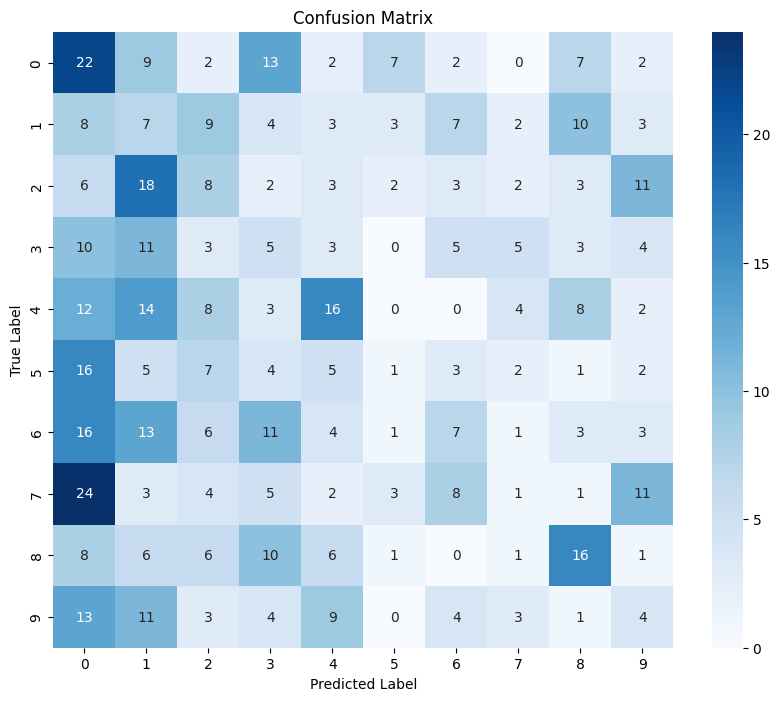

AttributeError: 'Subset' object has no attribute 'data'

In [2]:
# qbm_classifier.py

"""
Quantum Boltzmann Machine (QBM) for Nepali Numerals Classification.

This script implements a QBM using PennyLane and PyTorch to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QBM leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical k-NN for classification.

Directory Structure:
your_project/
├── qbm_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QBMClassifier.
    Args:
        log_file (str): Path to the log file.
    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QBMClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.
        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Boltzmann Machine (QBM) Definition
# ==============================
n_visible = 8
n_hidden = 8
n_qubits = n_visible + n_hidden  # Total qubits needed

dev = qml.device("default.qubit", wires=n_qubits)

class QBM:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, epochs=100, k=1):
        """
        Initializes the QBM.

        Args:
            n_visible (int): Number of visible units.
            n_hidden (int): Number of hidden units.
            learning_rate (float): Learning rate for weight updates.
            epochs (int): Number of training epochs.
            k (int): Number of Gibbs sampling steps (for future extensions).
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_qubits = n_visible + n_hidden
        self.weights = np.random.randn(self.n_visible, self.n_hidden) * 0.1  # Shape: (8, 8)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.k = k  # Number of Gibbs sampling steps

        # Define the QNode once during initialization
        self.circuit = self.create_qnode()

    def create_qnode(self):
        """
        Creates and returns the QNode for the QBM.
        """
        @qml.qnode(dev, interface='numpy', diff_method='parameter-shift')
        def circuit(weights, x):
            """
            Quantum feature map for QBM that encodes visible data x on the first n_visible qubits
            and applies rotation gates based on the learned weights for the hidden qubits.

            Args:
                weights (np.array): Weight matrix of shape (n_visible, n_hidden).
                x (np.array): Input data, shape (n_visible,).
            Returns:
                list: List of expectation values (floats) for each qubit.
            """
            qml.AngleEmbedding(x, wires=range(self.n_visible))

            for j in range(self.n_hidden):
                angle_j = np.dot(x, weights[:, j])
                qml.RY(angle_j, wires=self.n_visible + j)

            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        return circuit

    def quantum_kernel(self, weights, x):
        """
        Executes the quantum circuit and returns the expectation values.

        Args:
            weights (np.array): Weight matrix of shape (n_visible, n_hidden).
            x (np.array): Input data, shape (n_visible,).

        Returns:
            list: List of expectation values (floats) for each qubit.
        """
        return self.circuit(weights, x)

    def sample_qbm(self, x):
        """
        Samples from the QBM given input data x.

        Args:
            x (np.array): Input data, shape (n_visible,).

        Returns:
            np.array: Sampled data, shape (n_visible,).
        """
        # Execute the quantum circuit once
        samples = self.quantum_kernel(self.weights, x)
        samples_array = np.array(samples, dtype=float)

        # Binarize the expectation values
        sampled = (samples_array[:self.n_visible] > 0).astype(int)
        return sampled

    def compute_loss(self, data):
        """
        Computes the loss as the sum of squared differences between data and QBM samples.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).

        Returns:
            float: Loss value (average over all samples).
        """
        total = 0.0
        for sample in data:
            qbm_sample = self.sample_qbm(sample)
            total += np.sum((sample - qbm_sample) ** 2)
        return total / len(data)

    def contrastive_divergence(self, data):
        """
        Trains the QBM using Contrastive Divergence.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        for epoch in range(self.epochs):
            for idx, sample in enumerate(data):
                # Positive phase
                pos_grad = np.outer(sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Negative phase
                neg_sample = self.sample_qbm(sample)
                neg_grad = np.outer(neg_sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Update weights
                self.weights += self.learning_rate * (pos_grad - neg_grad)  # Shape: (8, 8)

                # Optional: Log progress for every 100 samples
                if idx % 100 == 0:
                    logger.info(f"Epoch {epoch+1}/{self.epochs}, Sample {idx}/{len(data)} processed.")

            if (epoch + 1) % 10 == 0:
                loss = self.compute_loss(data)
                weight_norm = np.linalg.norm(self.weights)
                logger.info(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}, Weight Norm: {weight_norm:.4f}")

    def train(self, data):
        """
        Public method to train the QBM.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        self.contrastive_divergence(data)

# ==============================
# QBM Classifier Definition
# ==============================
class QBMClassifier:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, qbm, k=3):
        """
        Initializes the QBMClassifier.

        Args:
            qbm (QBM): Trained QBM object.
            k (int): Number of neighbors for k-NN.
        """
        self.qbm = qbm
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        self.features = []
        self.labels = []

    def extract_features(self, data, labels):
        """
        Extracts features using the QBM and trains the k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
            labels (np.array): Corresponding labels, shape (n_samples,).
        """
        self.features = []
        self.labels = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            self.features.append(qbm_feature)
        self.features = np.array(self.features)
        self.labels = labels
        self.model.fit(self.features, self.labels)
        logger.info("k-NN classifier trained on QBM features.")

    def predict(self, data):
        """
        Predicts labels for the given data using the trained k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
        Returns:
            np.array: Predicted labels, shape (n_samples,).
        """
        test_features = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            test_features.append(qbm_feature)
        test_features = np.array(test_features)
        predictions = self.model.predict(test_features)
        return predictions

# ==============================
# Visualization Functions
# ==============================
def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.

    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(y_test, y_pred, test_loader, num_images=6):
    """
    Visualizes a few predictions from the classifier.

    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        test_loader (DataLoader): DataLoader for test data.
        num_images (int): Number of images to visualize.
    """
    # Collect all test data paths
    test_data_paths = []
    for dataset in test_loader.dataset.datasets if hasattr(test_loader.dataset, 'datasets') else [test_loader.dataset]:
        test_data_paths.extend(dataset.data)
    
    if num_images > len(y_test):
        num_images = len(y_test)
        print(f"Requested num_images exceeds test set size. Setting num_images to {num_images}.")

    indices = random.sample(range(len(y_test)), num_images)
    print("Selected indices for visualization:", indices)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        image_idx = indices[idx]
        try:
            image_path = test_data_paths[image_idx]
            label = y_test[image_idx]
            pred = y_pred[image_idx]
            img = Image.open(image_path).convert('L').resize((28, 28))
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
        except IndexError:
            print(f"IndexError: image_idx {image_idx} is out of bounds.")
            ax.axis('off')
            ax.set_title("Image not found")
    plt.tight_layout()
    plt.show()

# ==============================
# Training and Evaluation
# ==============================
def preprocess_data(loader, n_components=8):
    """
    Preprocesses the data by flattening, binarizing, and applying PCA.

    Args:
        loader (DataLoader): DataLoader object.
        n_components (int): Number of components for PCA.

    Returns:
        np.array: Preprocessed data, shape (n_samples, n_components).
        np.array: Corresponding labels.
    """
    data = []
    labels = []
    for images, lbls in loader:
        # Flatten images: 28x28 -> 784
        flattened = images.view(images.size(0), -1).numpy()
        # Binarize: pixel > 0.5 -> 1, else 0
        flattened = (flattened > 0.5).astype(int)
        data.append(flattened)
        labels.append(lbls.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA to reduce dimensionality for the quantum kernel
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    return data_pca, labels

def main():
    """
    Main function to initialize, train, and evaluate the QBM and QBMClassifier.
    """
    logger.info("Initializing Quantum Boltzmann Machine (QBM)")

    # Initialize data loaders
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR, batch_size=16)

    # Preprocess the data with PCA
    X_train, y_train = preprocess_data(train_loader, n_components=n_visible)
    X_test, y_test = preprocess_data(test_loader, n_components=n_visible)

    logger.info(f"Training data shape: {X_train.shape}")
    logger.info(f"Testing data shape: {X_test.shape}")

    # Initialize QBM
    qbm = QBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.05, epochs=3, k=1) # epoch default 100

    # Train QBM
    logger.info("Starting QBM training...")
    qbm.train(X_train)
    logger.info("QBM training completed.")

    # Initialize and train QBMClassifier
    classifier = QBMClassifier(qbm, k=3)
    logger.info("Extracting features and training k-NN classifier...")
    classifier.extract_features(X_train, y_train)
    logger.info("k-NN classifier training completed.")

    # Predict on test data
    logger.info("Predicting on test data...")
    y_pred = classifier.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")
    print(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

    # Visualize Predictions
    visualize_predictions(y_test, y_pred, test_loader, num_images=6)

if __name__ == "__main__":
    main()


In [3]:
# qbm_classifier.py

"""
Quantum Boltzmann Machine (QBM) for Nepali Numerals Classification.

This script implements a QBM using PennyLane and PyTorch to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QBM leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical k-NN for classification.

Directory Structure:
your_project/
├── qbm_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QBMClassifier.
    Args:
        log_file (str): Path to the log file.
    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QBMClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.
        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Boltzmann Machine (QBM) Definition
# ==============================
n_visible = 8
n_hidden = 8
n_qubits = n_visible + n_hidden  # Total qubits needed

dev = qml.device("default.qubit", wires=n_qubits)

class QBM:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, epochs=100, k=1):
        """
        Initializes the QBM.

        Args:
            n_visible (int): Number of visible units.
            n_hidden (int): Number of hidden units.
            learning_rate (float): Learning rate for weight updates.
            epochs (int): Number of training epochs.
            k (int): Number of Gibbs sampling steps (for future extensions).
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_qubits = n_visible + n_hidden
        self.weights = np.random.randn(self.n_visible, self.n_hidden) * 0.1  # Shape: (8, 8)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.k = k  # Number of Gibbs sampling steps

        # Define the QNode once during initialization
        self.circuit = self.create_qnode()

    def create_qnode(self):
        """
        Creates and returns the QNode for the QBM.
        """
        @qml.qnode(dev, interface='numpy', diff_method='parameter-shift')
        def circuit(weights, x):
            """
            Quantum feature map for QBM that encodes visible data x on the first n_visible qubits
            and applies rotation gates based on the learned weights for the hidden qubits.

            Args:
                weights (np.array): Weight matrix of shape (n_visible, n_hidden).
                x (np.array): Input data, shape (n_visible,).
            Returns:
                list: List of expectation values (floats) for each qubit.
            """
            qml.AngleEmbedding(x, wires=range(self.n_visible))

            for j in range(self.n_hidden):
                angle_j = np.dot(x, weights[:, j])
                qml.RY(angle_j, wires=self.n_visible + j)

            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        return circuit

    def quantum_kernel(self, weights, x):
        """
        Executes the quantum circuit and returns the expectation values.

        Args:
            weights (np.array): Weight matrix of shape (n_visible, n_hidden).
            x (np.array): Input data, shape (n_visible,).

        Returns:
            list: List of expectation values (floats) for each qubit.
        """
        return self.circuit(weights, x)

    def sample_qbm(self, x):
        """
        Samples from the QBM given input data x.

        Args:
            x (np.array): Input data, shape (n_visible,).

        Returns:
            np.array: Sampled data, shape (n_visible,).
        """
        # Execute the quantum circuit once
        samples = self.quantum_kernel(self.weights, x)
        samples_array = np.array(samples, dtype=float)

        # Binarize the expectation values
        sampled = (samples_array[:self.n_visible] > 0).astype(int)
        return sampled

    def compute_loss(self, data):
        """
        Computes the loss as the sum of squared differences between data and QBM samples.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).

        Returns:
            float: Loss value (average over all samples).
        """
        total = 0.0
        for sample in data:
            qbm_sample = self.sample_qbm(sample)
            total += np.sum((sample - qbm_sample) ** 2)
        return total / len(data)

    def contrastive_divergence(self, data):
        """
        Trains the QBM using Contrastive Divergence.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        for epoch in range(self.epochs):
            for idx, sample in enumerate(data):
                # Positive phase
                pos_grad = np.outer(sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Negative phase
                neg_sample = self.sample_qbm(sample)
                neg_grad = np.outer(neg_sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Update weights
                self.weights += self.learning_rate * (pos_grad - neg_grad)  # Shape: (8, 8)

                # Optional: Log progress for every 100 samples
                if idx % 100 == 0:
                    logger.info(f"Epoch {epoch+1}/{self.epochs}, Sample {idx}/{len(data)} processed.")

            if (epoch + 1) % 10 == 0:
                loss = self.compute_loss(data)
                weight_norm = np.linalg.norm(self.weights)
                logger.info(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}, Weight Norm: {weight_norm:.4f}")

    def train(self, data):
        """
        Public method to train the QBM.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        self.contrastive_divergence(data)

# ==============================
# QBM Classifier Definition
# ==============================
class QBMClassifier:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, qbm, k=3):
        """
        Initializes the QBMClassifier.

        Args:
            qbm (QBM): Trained QBM object.
            k (int): Number of neighbors for k-NN.
        """
        self.qbm = qbm
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        self.features = []
        self.labels = []

    def extract_features(self, data, labels):
        """
        Extracts features using the QBM and trains the k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
            labels (np.array): Corresponding labels, shape (n_samples,).
        """
        self.features = []
        self.labels = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            self.features.append(qbm_feature)
        self.features = np.array(self.features)
        self.labels = labels
        self.model.fit(self.features, self.labels)
        logger.info("k-NN classifier trained on QBM features.")

    def predict(self, data):
        """
        Predicts labels for the given data using the trained k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
        Returns:
            np.array: Predicted labels, shape (n_samples,).
        """
        test_features = []
        for sample in data:
            qbm_feature = self.qbm.sample_qbm(sample)
            test_features.append(qbm_feature)
        test_features = np.array(test_features)
        predictions = self.model.predict(test_features)
        return predictions

# ==============================
# Visualization Functions
# ==============================
def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.

    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(y_test, y_pred, test_loader, num_images=6):
    """
    Visualizes a few predictions from the classifier.

    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        test_loader (DataLoader): DataLoader for test data.
        num_images (int): Number of images to visualize.
    """
    # Collect all test data paths
    test_data_paths = []
    if isinstance(test_loader.dataset, torch.utils.data.Subset):
        original_dataset = test_loader.dataset.dataset
        subset_indices = test_loader.dataset.indices
        test_data_paths = [original_dataset.data[idx] for idx in subset_indices]
    else:
        for dataset in test_loader.dataset.datasets if hasattr(test_loader.dataset, 'datasets') else [test_loader.dataset]:
            test_data_paths.extend(dataset.data)

    # Ensure that the number of images to visualize does not exceed the test set size
    if num_images > len(y_test):
        num_images = len(y_test)
        print(f"Requested num_images exceeds test set size. Setting num_images to {num_images}.")

    # Randomly select indices for visualization
    selected_indices = random.sample(range(len(y_test)), num_images)
    print("Selected indices for visualization:", selected_indices)

    # Set up the plotting grid
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in zip(selected_indices, axes):
        try:
            image_path = test_data_paths[idx]
            label = y_test[idx]
            pred = y_pred[idx]
            # Load and preprocess the image
            img = Image.open(image_path).convert('L').resize((28, 28))
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
        except IndexError:
            print(f"IndexError: image_idx {idx} is out of bounds.")
            ax.axis('off')
            ax.set_title("Image not found")
    plt.tight_layout()
    plt.show()

# ==============================
# Training and Evaluation
# ==============================
def preprocess_data(loader, n_components=8):
    """
    Preprocesses the data by flattening, binarizing, and applying PCA.

    Args:
        loader (DataLoader): DataLoader object.
        n_components (int): Number of components for PCA.

    Returns:
        np.array: Preprocessed data, shape (n_samples, n_components).
        np.array: Corresponding labels.
    """
    data = []
    labels = []
    for images, lbls in loader:
        # Flatten images: 28x28 -> 784
        flattened = images.view(images.size(0), -1).numpy()
        # Binarize: pixel > 0.5 -> 1, else 0
        flattened = (flattened > 0.5).astype(int)
        data.append(flattened)
        labels.append(lbls.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA to reduce dimensionality for the quantum kernel
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    return data_pca, labels

def main():
    """
    Main function to initialize, train, and evaluate the QBM and QBMClassifier.
    """
    logger.info("Initializing Quantum Boltzmann Machine (QBM)")

    # Initialize data loaders
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR, batch_size=16)

    # Preprocess the data with PCA
    X_train, y_train = preprocess_data(train_loader, n_components=n_visible)
    X_test, y_test = preprocess_data(test_loader, n_components=n_visible)

    logger.info(f"Training data shape: {X_train.shape}")
    logger.info(f"Testing data shape: {X_test.shape}")

    # Initialize QBM
    qbm = QBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.05, epochs=100, k=1)

    # Train QBM
    logger.info("Starting QBM training...")
    qbm.train(X_train)
    logger.info("QBM training completed.")

    # Initialize and train QBMClassifier
    classifier = QBMClassifier(qbm, k=3)
    logger.info("Extracting features and training k-NN classifier...")
    classifier.extract_features(X_train, y_train)
    logger.info("k-NN classifier training completed.")

    # Predict on test data
    logger.info("Predicting on test data...")
    y_pred = classifier.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")
    print(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

    # Visualize Predictions
    visualize_predictions(y_test, y_pred, test_loader, num_images=6)

if __name__ == "__main__":
    main()


2024-12-25 16:20:09,752 - INFO - Initializing Quantum Boltzmann Machine (QBM)
2024-12-25 16:20:09,753 - INFO - Initializing Data Loaders
2024-12-25 16:20:09,754 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:20:09,775 - INFO - Loaded 2880 samples.
2024-12-25 16:20:09,786 - INFO - Data Loaders initialized: 2304 training samples, 576 testing samples
2024-12-25 16:20:18,761 - INFO - Training data shape: (2304, 8)
2024-12-25 16:20:18,764 - INFO - Testing data shape: (576, 8)
2024-12-25 16:20:18,767 - INFO - Starting QBM training...
2024-12-25 16:20:19,053 - INFO - Epoch 1/100, Sample 0/2304 processed.
2024-12-25 16:20:22,327 - INFO - Epoch 1/100, Sample 100/2304 processed.
2024-12-25 16:20:24,992 - INFO - Epoch 1/100, Sample 200/2304 processed.
2024-12-25 16:20:27,755 - INFO - Epoch 1/100, Sample 300/2304 processed.
2024-12-25 16:20:30,896 - INFO - Epoch 1/100, Sample 400/2304 processed.
2024-12-25 16:20:34,121 - INF

KeyboardInterrupt: 

2024-12-25 16:25:53,235 - INFO - Initializing Quantum Boltzmann Machine (QBM)
2024-12-25 16:25:53,237 - INFO - Initializing Data Loaders
2024-12-25 16:25:53,237 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:25:53,269 - INFO - Loaded 2880 samples.
2024-12-25 16:25:53,272 - INFO - Data Loaders initialized: 2304 training samples, 576 testing samples
2024-12-25 16:25:53,272 - INFO - Preprocessing training data...
2024-12-25 16:25:58,321 - INFO - Preprocessing testing data...
2024-12-25 16:26:01,654 - INFO - Training data shape: (2304, 8)
2024-12-25 16:26:01,657 - INFO - Testing data shape: (576, 8)
2024-12-25 16:26:01,663 - INFO - Starting QBM training...
2024-12-25 16:26:01,664 - INFO - Starting Epoch 1/3
Epoch 1/3: 100%|██████████| 2304/2304 [00:09<00:00, 252.50it/s]
2024-12-25 16:26:10,819 - INFO - Starting Epoch 2/3
Epoch 2/3: 100%|██████████| 2304/2304 [00:09<00:00, 254.17it/s]
2024-12-25 16:26:19,886 - INFO - 

QBM Classifier Accuracy: 15.10%
Confusion Matrix:
[[22  9  2 13  2  7  2  0  7  2]
 [ 8  7  9  4  3  3  7  2 10  3]
 [ 6 18  8  2  3  2  3  2  3 11]
 [10 11  3  5  3  0  5  5  3  4]
 [12 14  8  3 16  0  0  4  8  2]
 [16  5  7  4  5  1  3  2  1  2]
 [16 13  6 11  4  1  7  1  3  3]
 [24  3  4  5  2  3  8  1  1 11]
 [ 8  6  6 10  6  1  0  1 16  1]
 [13 11  3  4  9  0  4  3  1  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.33      0.22        66
           1       0.07      0.12      0.09        56
           2       0.14      0.14      0.14        58
           3       0.08      0.10      0.09        49
           4       0.30      0.24      0.27        67
           5       0.06      0.02      0.03        46
           6       0.18      0.11      0.13        65
           7       0.05      0.02      0.02        62
           8       0.30      0.29      0.30        55
           9       0.09      0.08      0.08        52



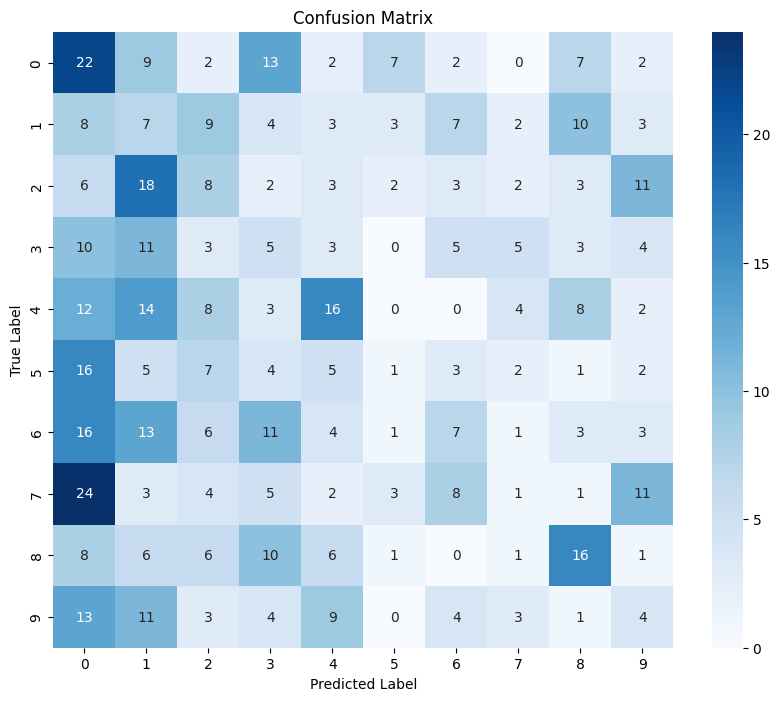

Selected indices for visualization: [114, 25, 281, 250, 228, 142]


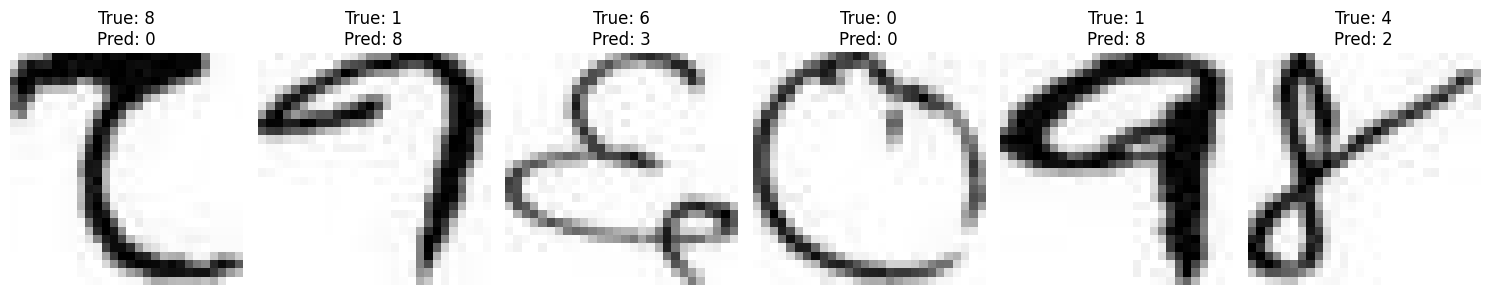

2024-12-25 16:26:40,559 - INFO - Evaluating k-NN classifier without QBM...
2024-12-25 16:26:40,576 - INFO - k-NN Classifier Accuracy without QBM: 58.51%


k-NN Classifier Accuracy without QBM: 58.51%
Confusion Matrix:
[[57  1  0  1  0  0  0  4  2  1]
 [ 0 30 17  9  0  0  0  0  0  0]
 [ 0  0 24  9  0 22  2  0  0  1]
 [ 0  0  5 23  2  5 10  2  1  1]
 [ 0 12  0  4 41  7  3  0  0  0]
 [ 0  2  3 17  7 15  1  0  0  1]
 [ 2  2  2  3  4  0 48  2  1  1]
 [13  1  1  7  5  1  6 26  2  0]
 [ 0  2  0  0  5  0  0  1 41  6]
 [ 0  7  3  0  7  2  1  0  0 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        66
           1       0.53      0.54      0.53        56
           2       0.44      0.41      0.42        58
           3       0.32      0.47      0.38        49
           4       0.58      0.61      0.59        67
           5       0.29      0.33      0.31        46
           6       0.68      0.74      0.71        65
           7       0.74      0.42      0.54        62
           8       0.87      0.75      0.80        55
           9       0.74      0.62      0.6

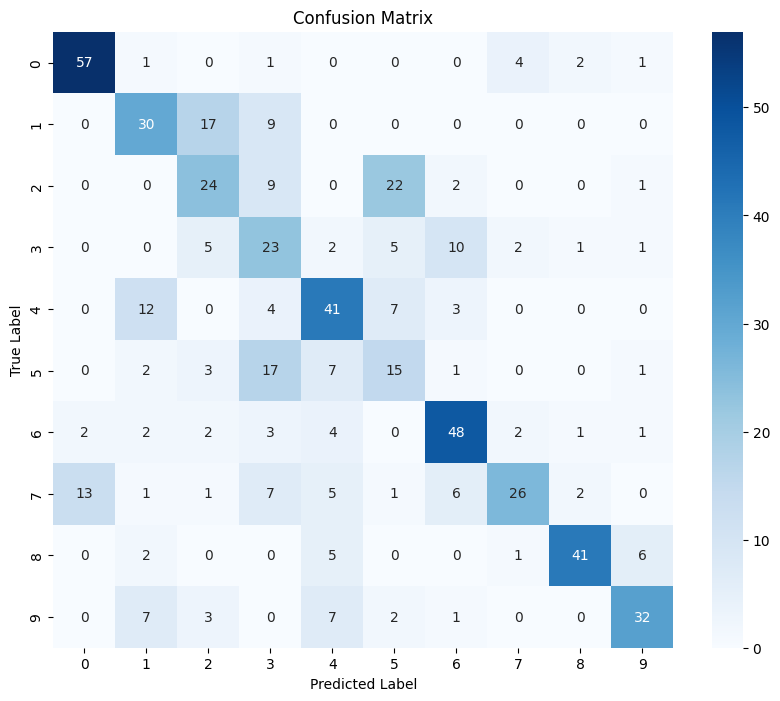

In [4]:
# qbm_classifier.py

"""
Quantum Boltzmann Machine (QBM) for Nepali Numerals Classification.

This script implements a QBM using PennyLane and PyTorch to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QBM leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical k-NN for classification.

Directory Structure:
your_project/
├── qbm_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bars

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QBMClassifier.

    Args:
        log_file (str): Path to the log file.

    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QBMClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.

        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.

    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.

    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Boltzmann Machine (QBM) Definition
# ==============================
n_visible = 8
n_hidden = 8
n_qubits = n_visible + n_hidden  # Total qubits needed

# Switch to a faster quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

class QBM:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, epochs=100, k=1):
        """
        Initializes the QBM.

        Args:
            n_visible (int): Number of visible units.
            n_hidden (int): Number of hidden units.
            learning_rate (float): Learning rate for weight updates.
            epochs (int): Number of training epochs.
            k (int): Number of Gibbs sampling steps (for future extensions).
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_qubits = n_visible + n_hidden
        self.weights = np.random.randn(self.n_visible, self.n_hidden) * 0.1  # Shape: (8, 8)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.k = k  # Number of Gibbs sampling steps

        # Define the QNode once during initialization
        self.circuit = self.create_qnode()

    def create_qnode(self):
        """
        Creates and returns the QNode for the QBM.

        Returns:
            function: The compiled QNode.
        """
        @qml.qnode(dev, interface='numpy', diff_method='parameter-shift')
        def circuit(weights, x):
            """
            Quantum feature map for QBM that encodes visible data x on the first n_visible qubits
            and applies rotation gates based on the learned weights for the hidden qubits.

            Args:
                weights (np.array): Weight matrix of shape (n_visible, n_hidden).
                x (np.array): Input data, shape (n_visible,).
            Returns:
                list: List of expectation values (floats) for each qubit.
            """
            qml.AngleEmbedding(x, wires=range(self.n_visible))

            for j in range(self.n_hidden):
                angle_j = np.dot(x, weights[:, j])
                qml.RY(angle_j, wires=self.n_visible + j)

            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        return circuit

    def quantum_kernel(self, weights, x):
        """
        Executes the quantum circuit and returns the expectation values.

        Args:
            weights (np.array): Weight matrix of shape (n_visible, n_hidden).
            x (np.array): Input data, shape (n_visible,).

        Returns:
            list: List of expectation values (floats) for each qubit.
        """
        return self.circuit(weights, x)

    def sample_qbm(self, x):
        """
        Samples from the QBM given input data x.

        Args:
            x (np.array): Input data, shape (n_visible,).

        Returns:
            np.array: Sampled data, shape (n_visible,).
        """
        # Execute the quantum circuit once
        samples = self.quantum_kernel(self.weights, x)
        samples_array = np.array(samples, dtype=float)

        # Binarize the expectation values
        sampled = (samples_array[:self.n_visible] > 0).astype(int)
        return sampled

    def compute_loss(self, data):
        """
        Computes the loss as the sum of squared differences between data and QBM samples.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).

        Returns:
            float: Loss value (average over all samples).
        """
        total = 0.0
        for sample in data:
            qbm_sample = self.sample_qbm(sample)
            total += np.sum((sample - qbm_sample) ** 2)
        return total / len(data)

    def contrastive_divergence(self, data):
        """
        Trains the QBM using Contrastive Divergence.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        for epoch in range(self.epochs):
            logger.info(f"Starting Epoch {epoch+1}/{self.epochs}")
            for idx, sample in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{self.epochs}")):
                # Positive phase
                pos_grad = np.outer(sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Negative phase
                neg_sample = self.sample_qbm(sample)
                neg_grad = np.outer(neg_sample, np.ones(self.n_hidden))  # Shape: (8, 8)

                # Update weights
                self.weights += self.learning_rate * (pos_grad - neg_grad)  # Shape: (8, 8)

            if (epoch + 1) % 10 == 0:
                loss = self.compute_loss(data)
                weight_norm = np.linalg.norm(self.weights)
                logger.info(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}, Weight Norm: {weight_norm:.4f}")

    def train(self, data):
        """
        Public method to train the QBM.

        Args:
            data (np.array): Training data, shape (n_samples, n_visible).
        """
        self.contrastive_divergence(data)

# ==============================
# QBM Classifier Definition
# ==============================
class QBMClassifier:
    """
    Quantum Boltzmann Machine (QBM) Classifier.
    """
    def __init__(self, qbm, k=3):
        """
        Initializes the QBMClassifier.

        Args:
            qbm (QBM): Trained QBM object.
            k (int): Number of neighbors for k-NN.
        """
        self.qbm = qbm
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        self.features = []
        self.labels = []

    def extract_features(self, data, labels):
        """
        Extracts features using the QBM and trains the k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
            labels (np.array): Corresponding labels, shape (n_samples,).
        """
        logger.info("Extracting QBM features for k-NN training...")
        self.features = []
        self.labels = []
        for sample in tqdm(data, desc="Extracting features"):
            qbm_feature = self.qbm.sample_qbm(sample)
            self.features.append(qbm_feature)
        self.features = np.array(self.features)
        self.labels = labels
        self.model.fit(self.features, self.labels)
        logger.info("k-NN classifier trained on QBM features.")

    def predict(self, data):
        """
        Predicts labels for the given data using the trained k-NN classifier.

        Args:
            data (np.array): Input data, shape (n_samples, n_visible).
        Returns:
            np.array: Predicted labels, shape (n_samples,).
        """
        logger.info("Extracting QBM features for k-NN prediction...")
        test_features = []
        for sample in tqdm(data, desc="Extracting test features"):
            qbm_feature = self.qbm.sample_qbm(sample)
            test_features.append(qbm_feature)
        test_features = np.array(test_features)
        predictions = self.model.predict(test_features)
        return predictions

# ==============================
# Visualization Functions
# ==============================
def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.

    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_predictions(y_test, y_pred, test_loader, num_images=6):
    """
    Visualizes a few predictions from the classifier.

    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        test_loader (DataLoader): DataLoader for test data.
        num_images (int): Number of images to visualize.
    """
    # Collect all test data paths
    test_data_paths = []
    if isinstance(test_loader.dataset, torch.utils.data.Subset):
        original_dataset = test_loader.dataset.dataset
        subset_indices = test_loader.dataset.indices
        test_data_paths = [original_dataset.data[idx] for idx in subset_indices]
    else:
        for dataset in test_loader.dataset.datasets if hasattr(test_loader.dataset, 'datasets') else [test_loader.dataset]:
            test_data_paths.extend(dataset.data)

    # Ensure that the number of images to visualize does not exceed the test set size
    if num_images > len(y_test):
        num_images = len(y_test)
        print(f"Requested num_images exceeds test set size. Setting num_images to {num_images}.")

    # Randomly select indices for visualization
    selected_indices = random.sample(range(len(y_test)), num_images)
    print("Selected indices for visualization:", selected_indices)

    # Set up the plotting grid
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in zip(selected_indices, axes):
        try:
            image_path = test_data_paths[idx]
            label = y_test[idx]
            pred = y_pred[idx]
            # Load and preprocess the image
            img = Image.open(image_path).convert('L').resize((28, 28))
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
        except IndexError:
            print(f"IndexError: image_idx {idx} is out of bounds.")
            ax.axis('off')
            ax.set_title("Image not found")
    plt.tight_layout()
    plt.show()

# ==============================
# Training and Evaluation
# ==============================
def preprocess_data(loader, n_components=8):
    """
    Preprocesses the data by flattening, binarizing, and applying PCA.

    Args:
        loader (DataLoader): DataLoader object.
        n_components (int): Number of components for PCA.

    Returns:
        np.array: Preprocessed data, shape (n_samples, n_components).
        np.array: Corresponding labels.
    """
    data = []
    labels = []
    for images, lbls in loader:
        # Flatten images: 28x28 -> 784
        flattened = images.view(images.size(0), -1).numpy()
        # Binarize: pixel > 0.5 -> 1, else 0
        flattened = (flattened > 0.5).astype(int)
        data.append(flattened)
        labels.append(lbls.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply PCA to reduce dimensionality for the quantum kernel
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    return data_pca, labels

def evaluate_knn_without_qbm(X_train, y_train, X_test, y_test, k=3):
    """
    Evaluates a k-NN classifier without QBM feature extraction.

    Args:
        X_train (np.array): Training data, shape (n_samples, n_features).
        y_train (np.array): Training labels, shape (n_samples,).
        X_test (np.array): Testing data, shape (n_samples, n_features).
        y_test (np.array): Testing labels, shape (n_samples,).
        k (int): Number of neighbors.

    Returns:
        None
    """
    logger.info("Evaluating k-NN classifier without QBM...")
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"k-NN Classifier Accuracy without QBM: {accuracy * 100:.2f}%")
    print(f"k-NN Classifier Accuracy without QBM: {accuracy * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

def main():
    """
    Main function to initialize, train, and evaluate the QBM and QBMClassifier.
    """
    logger.info("Initializing Quantum Boltzmann Machine (QBM)")

    # Initialize data loaders
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR, batch_size=16)

    # Preprocess the data with PCA
    logger.info("Preprocessing training data...")
    X_train, y_train = preprocess_data(train_loader, n_components=n_visible)
    logger.info("Preprocessing testing data...")
    X_test, y_test = preprocess_data(test_loader, n_components=n_visible)

    logger.info(f"Training data shape: {X_train.shape}")
    logger.info(f"Testing data shape: {X_test.shape}")

    # Initialize QBM
    qbm = QBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=0.05, epochs=3, k=1) # defalt epochs=100

    # Train QBM
    logger.info("Starting QBM training...")
    qbm.train(X_train)
    logger.info("QBM training completed.")

    # Initialize and train QBMClassifier
    classifier = QBMClassifier(qbm, k=3)
    logger.info("Extracting features and training k-NN classifier with QBM features...")
    classifier.extract_features(X_train, y_train)
    logger.info("k-NN classifier training completed.")

    # Predict on test data
    logger.info("Predicting on test data using QBM features and k-NN classifier...")
    y_pred = classifier.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")
    print(f"QBM Classifier Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

    # Visualize Predictions
    visualize_predictions(y_test, y_pred, test_loader, num_images=6)

    # Benchmark: Evaluate k-NN without QBM
    evaluate_knn_without_qbm(X_train, y_train, X_test, y_test, k=3)

if __name__ == "__main__":
    main()
